# Compare supervised and unsupervised methods of determining metapath importance

This notebook evaluates how well the sum of negative logs of metapath p_values agrees with the supervised rankings found in Rephetio. Our dataset of choice is the set of compounds connected to epilepsy with length 3 or less metapaths

In [1]:
import math

from matplotlib import pyplot as plt
import pandas
from plotnine import *
import scipy
from scipy import stats
import tqdm

from src.database_utils import get_db_connection

In [2]:
epilepsy_id = 'DOID:1826'

supervised_predictions_df = pandas.read_csv('https://raw.githubusercontent.com/dhimmel/learn/b2460a1ecdec1078d673634688784f3eb5e3fc43/prediction/predictions/probabilities.tsv', sep='\t')

In [3]:
query_template = '''\
SELECT dwpc, p_value, metapath_id, source_node.name AS source_name, 
         target_node.name AS target_name, source_node.identifier AS source_identifier 
FROM dj_hetmech_app_pathcount pc 
JOIN dj_hetmech_app_node source_node 
   ON pc.source_id = source_node.id 
JOIN dj_hetmech_app_node target_node 
   ON pc.target_id = target_node.id     
WHERE target_node.identifier='{disease_id}' OR source_node.identifier='{disease_id}'
ORDER BY pc.p_value
'''

def construct_disease_query(disease_id):
    # If this query is used for different node types, it may be necessary to add an additional condition
    # that the matching node is of the correct type e.g. Disease
    return query_template.format(disease_id=disease_id)

def get_disease_df(disease_id, supervised_predictions_df):
    query = construct_disease_query(disease_id)
    connection = get_db_connection()

    # Get the unsupervised compound information for a given disease
    metapaths = pandas.read_sql(query, connection)

    # If the source node is a disease instead of a compound, swap it with the target node
    reversed_indices = metapaths['source_identifier'] == disease_id
    metapaths['temp'] = metapaths['source_name']
    metapaths.loc[reversed_indices, 'source_name'] = metapaths['target_name']
    metapaths.loc[reversed_indices, 'target_name'] = metapaths['temp']

    metapaths.drop(['temp', 'source_identifier'], axis=1)
    
    metapaths = metapaths.sort_values(by=['source_name', 'metapath_id'])
    # Ensure that you only have one copy of each (source_name, metapath_id) pair
    metapaths = metapaths.drop_duplicates(subset=['source_name', 'metapath_id'])
    # Remove any rows with NaN values
    metapaths = metapaths.dropna()
    min_p_value = metapaths[metapaths.p_value != 0].p_value.min()
    # Replace zero p-values to keep the log conversion from breaking
    metapaths.loc[metapaths.p_value == 0, 'p_value'] = min_p_value
    metapaths['neg_log_p_value'] = metapaths.p_value.apply(lambda x: -math.log10(x))

    max_column = metapaths.groupby('source_name')['neg_log_p_value'].max()
    mean_column = metapaths.groupby('source_name')['neg_log_p_value'].mean()

    neg_log_sum = metapaths.groupby('source_name').sum()
    neg_log_sum = neg_log_sum.sort_values(by='neg_log_p_value', ascending=False)
    # TODO drop dwpc and p_value
    neg_log_sum['max_neg_log'] = max_column
    neg_log_sum['mean_neg_log'] = mean_column
    neg_log_sum['max_percent_of_total'] = 100 * (neg_log_sum['max_neg_log'] / neg_log_sum['neg_log_p_value'])

    disease_predictions_df = supervised_predictions_df[supervised_predictions_df.disease_id == disease_id]
    # Remove predictions on drugs not in the other dataframe
    disease_predictions_df = disease_predictions_df[disease_predictions_df.compound_name.isin(neg_log_sum.index)]
    disease_predictions_df = disease_predictions_df.sort_values(by='disease_percentile', ascending=False)

    # Get the unsupervised compound ranking
    neg_log_sum = neg_log_sum.reset_index()
    neg_log_sum['unsupervised_rank'] = neg_log_sum.index

    # Sort neg_log_sum matching names in disease_predicitons_df 
    combined_df = neg_log_sum.merge(disease_predictions_df, how="left", right_on='compound_name', left_on='source_name')

    combined_df = combined_df.sort_values(by='disease_percentile', ascending=False).reset_index(drop=True)
    combined_df['supervised_rank'] = combined_df.index.copy()

    return combined_df


In [ ]:
%%time
epilepsy_df = get_disease_df(epilepsy_id, supervised_predictions_df)

Text(0, 0.5, 'Unsupervised drug rank')

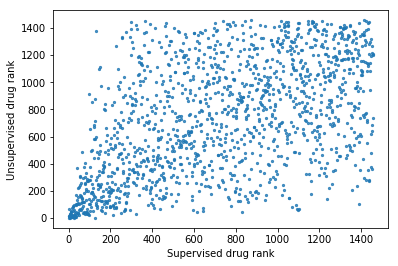

In [5]:
plt.scatter(epilepsy_df['supervised_rank'], epilepsy_df['unsupervised_rank'], alpha=.8, s=5)
plt.xlabel('Supervised drug rank')
plt.ylabel('Unsupervised drug rank')

In [6]:
scipy.stats.kendalltau(epilepsy_df.index, epilepsy_df['unsupervised_rank'])

KendalltauResult(correlation=0.3692377651807226, pvalue=4.891309138488568e-99)

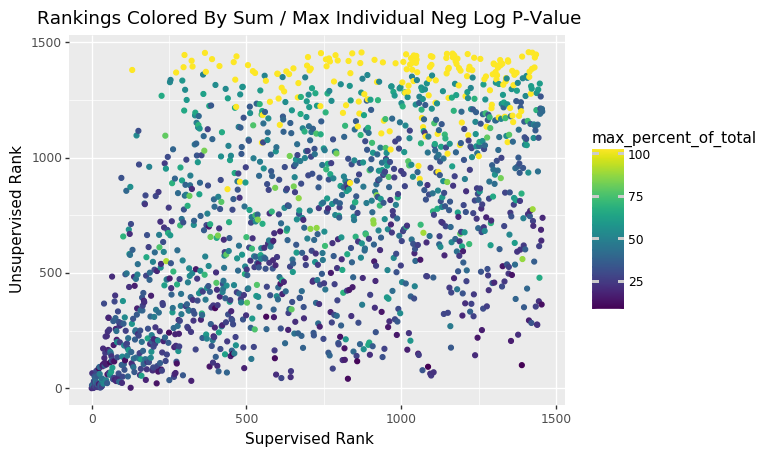

<ggplot: (-9223363257716728078)>

In [7]:
(ggplot(epilepsy_df, aes('supervised_rank', 'unsupervised_rank', color='max_percent_of_total')) 
+ geom_point()
+ labs(x = 'Supervised Rank', y = 'Unsupervised Rank')
+ ggtitle('Rankings Colored By Sum / Max Individual Neg Log P-Value')
)

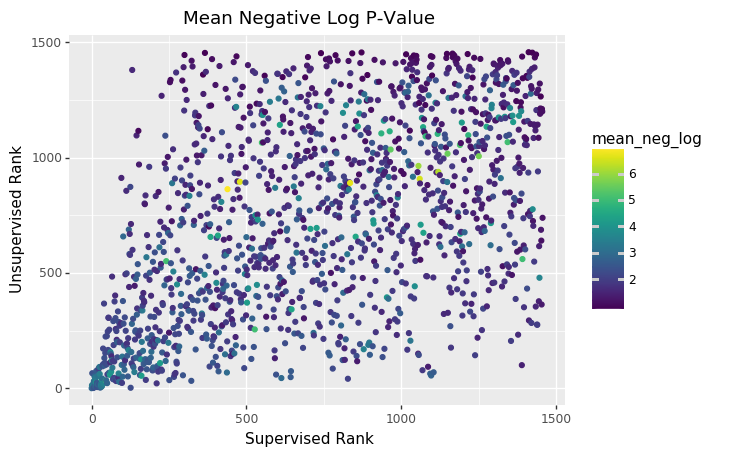

<ggplot: (-9223363257716658891)>

In [8]:
(ggplot(epilepsy_df, aes('supervised_rank', 'unsupervised_rank', color='mean_neg_log')) 
+ geom_point()
+ labs(x = 'Supervised Rank', y = 'Unsupervised Rank')
+ ggtitle('Mean Negative Log P-Value')
)

In [9]:
epilepsy_df['status_drugcentral'] = epilepsy_df['status_drugcentral'].astype('category')

epilepsy_df[epilepsy_df['status_drugcentral'] == 1]

,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank
1,Ethotoin,40.308889,0.135975,34.047045,11.163887,3.404705,32.789592,12,DB00754,Ethotoin,...,0,0.00000,0.588531,NaN,1.000000,0.999350,0.0,0.0,1.0,1
5,Lorazepam,46.654248,0.254532,37.391029,16.152869,3.115919,43.199853,6,DB00186,Lorazepam,...,0,0.00000,0.488540,NaN,1.000000,0.996749,11.0,1.0,1.0,5
8,Methsuximide,41.758631,0.078019,30.629448,8.429114,3.062945,27.519642,29,DB05246,Methsuximide,...,0,0.00000,0.434328,NaN,1.000000,0.994798,0.0,0.0,1.0,8
29,Pentobarbital,51.146924,0.400942,39.949409,13.585391,2.853529,34.006487,4,DB00312,Pentobarbital,...,0,0.00000,0.146912,NaN,1.000000,0.981144,1.0,1.0,1.0,29
31,Secobarbital,37.865404,0.156629,35.467881,14.509167,3.546788,40.907905,10,DB00418,Secobarbital,...,0,0.00000,0.131900,NaN,1.000000,0.979844,0.0,0.0,1.0,31
36,Methylphenobarbital,35.630636,0.153065,21.615138,3.836522,2.401682,17.749238,102,DB00849,Methylphenobarbital,...,0,0.00000,0.114096,NaN,1.000000,0.976593,0.0,0.0,1.0,36
38,Nitrazepam,32.305844,0.213415,32.443425,16.504204,3.604825,50.870722,20,DB01595,Nitrazepam,...,0,0.00000,0.104291,NaN,1.000000,0.975293,0.0,0.0,1.0,38
44,Thiopental,30.310554,0.124824,18.549627,4.877034,2.318703,26.291817,153,DB00599,Thiopental,...,0,0.00000,0.098679,NaN,1.000000,0.971391,1.0,1.0,1.0,44
61,Ethosuximide,19.780452,0.082619,18.242788,8.991578,3.648558,49.288398,156,DB00593,Ethosuximide,...,0,0.00000,0.072529,NaN,1.000000,0.960338,1.0,1.0,1.0,61
73,Phensuximide,37.926910,0.199822,20.502213,3.039454,2.050221,14.825003,116,DB00832,Phensuximide,...,0,0.00000,0.048725,NaN,1.000000,0.952536,0.0,0.0,1.0,73


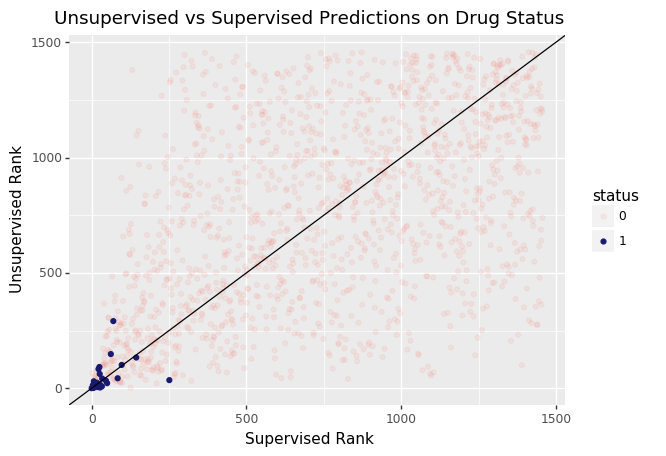

<ggplot: (-9223363257716673788)>

In [10]:
epilepsy_df['status'] = epilepsy_df['status'].astype('category')

(ggplot(epilepsy_df, aes('supervised_rank', 'unsupervised_rank', color='status', alpha='status')) 
+ geom_point()
+ labs(x = 'Supervised Rank', y = 'Unsupervised Rank')
+ geom_abline(intercept=0, slope=1)
+ scale_color_manual(['salmon', 'midnightblue'])
+ ggtitle('Unsupervised vs Supervised Predictions on Drug Status')
)

In [11]:
# Find the items with the biggest difference between the unsupervised and supervised ranks
epilepsy_df['rank_difference'] = epilepsy_df['unsupervised_rank'] - epilepsy_df['supervised_rank']
epilepsy_df = epilepsy_df.sort_values(by='rank_difference', ascending=True)

epilepsy_df.head()

,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank,rank_difference
1390,Betamethasone,55.783158,0.539277,21.757553,2.380723,1.554111,10.942054,100,DB00443,Betamethasone,...,0.3492,0.000968,0.031303,0.661765,0.055267,0.0,0.0,0.0,1390,-1290
1440,Acetyldigitoxin,23.716495,0.151398,14.457148,3.502783,2.065307,24.228728,275,DB00511,Acetyldigitoxin,...,0.0000,0.000637,NaN,0.242647,0.012354,0.0,0.0,0.0,1440,-1165
1439,Deslanoside,23.716495,0.151398,14.457148,3.502783,2.065307,24.228728,276,DB01078,Deslanoside,...,0.0000,0.000637,NaN,0.242647,0.012354,0.0,0.0,0.0,1439,-1163
1355,Triamcinolone,32.611289,0.207258,16.373477,2.939707,2.046685,17.954081,205,DB00620,Triamcinolone,...,0.3772,0.001081,0.037798,0.713235,0.078023,NaN,NaN,NaN,1355,-1150
1378,Methylprednisolone,37.133385,0.339155,15.555329,3.546533,1.728370,22.799472,232,DB00959,Methylprednisolone,...,0.3215,0.001013,0.030082,0.757353,0.063069,4.0,1.0,0.0,1378,-1146


In [12]:
epilepsy_df.tail()

,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank,rank_difference
297,Cisplatin,2.724715,0.032850,1.483470,1.483470,1.483470,100.0,1392,DB00515,Cisplatin,...,0.262,0.008713,0.179898,0.742647,0.806892,0.0,0.0,0.0,297,1095
273,SIMEPREVIR,1.888859,0.014863,1.827884,1.827884,1.827884,100.0,1369,DB06290,SIMEPREVIR,...,0.000,0.009575,NaN,0.948529,0.822497,0.0,0.0,0.0,273,1096
323,Deferasirox,3.225421,0.055395,1.256526,1.256526,1.256526,100.0,1420,DB01609,Deferasirox,...,0.000,0.007998,NaN,0.985294,0.789987,0.0,0.0,0.0,323,1097
300,Apixaban,2.801415,0.082143,1.085432,1.085432,1.085432,100.0,1445,DB06605,Apixaban,...,0.000,0.008667,NaN,0.985294,0.804941,0.0,0.0,0.0,300,1145
131,Piroxicam,4.288716,0.021694,1.663666,1.663666,1.663666,100.0,1380,DB00554,Piroxicam,...,0.000,0.019792,NaN,0.985294,0.914824,0.0,0.0,0.0,131,1249


In [13]:
epilepsy_df[epilepsy_df['source_name'] == 'Cisplatin']

,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank,rank_difference
297,Cisplatin,2.724715,0.03285,1.48347,1.48347,1.48347,100.0,1392,DB00515,Cisplatin,...,0.262,0.008713,0.179898,0.742647,0.806892,0.0,0.0,0.0,297,1095


In [14]:
epilepsy_df[epilepsy_df['source_name'] == 'Betamethasone']

,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank,rank_difference
1390,Betamethasone,55.783158,0.539277,21.757553,2.380723,1.554111,10.942054,100,DB00443,Betamethasone,...,0.3492,0.000968,0.031303,0.661765,0.055267,0.0,0.0,0.0,1390,-1290


# Test another disease
Let's see if the good performance we saw on epilepsy holds on less studied diseases like Barrett's esophagus.

In [15]:
barretts_id = 'DOID:9206'
barretts_df = get_disease_df(barretts_id, supervised_predictions_df)

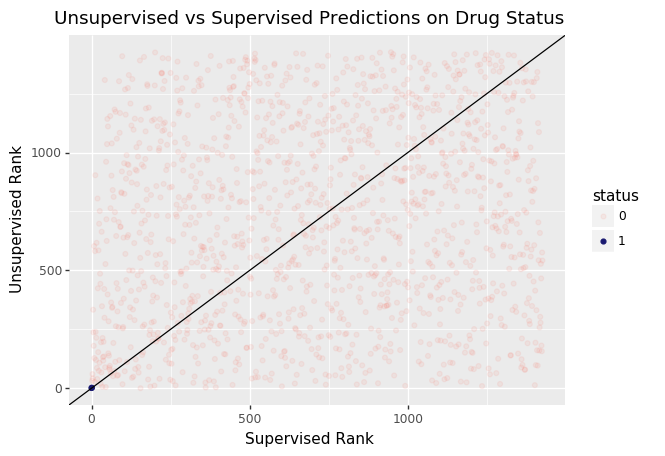

<ggplot: (-9223363257716618359)>

In [16]:
barretts_df['status'] = barretts_df['status'].astype('category')

(ggplot(barretts_df, aes('supervised_rank', 'unsupervised_rank', color='status', alpha='status')) 
+ geom_point()
+ labs(x = 'Supervised Rank', y = 'Unsupervised Rank')
+ geom_abline(intercept=0, slope=1)
+ scale_color_manual(['salmon', 'midnightblue'])
+ ggtitle('Unsupervised vs Supervised Predictions on Drug Status')
)

# All Diseases
Since the unsupervised prediction worked well for Barett's esophagus, let's see how well it works on all diseases

In [17]:
# Get unsupervised rankings and merge them with the supervised to get status
# Add the unsupervised and supervised ranks of all compounds with status=1 to lists
# plot histograms

disease_ids = supervised_predictions_df['disease_id'].unique()
supervised_ranks = []
unsupervised_ranks = []

for disease_id in tqdm.tqdm_notebook(disease_ids):
    disease_df = get_disease_df(disease_id, supervised_predictions_df)
    
    supervised_ranks.append(disease_df[disease_df['status'] == 1]['supervised_rank'])
    unsupervised_ranks.append(disease_df[disease_df['status'] == 1]['unsupervised_rank'])

unsupervised_ranks = unsupervised_ranks[0].append(unsupervised_ranks[1:], ignore_index=True)
supervised_ranks = supervised_ranks[0].append(supervised_ranks[1:], ignore_index=True)

In [18]:
rank_df = pandas.DataFrame({'Unsupervised': unsupervised_ranks, 'Supervised': supervised_ranks})
melted_df = rank_df.melt()

melted_df.columns = ['Ranking Method', 'Rank']

In [19]:
melted_df.head()

,Ranking Method,Rank
0,Unsupervised,57
1,Unsupervised,66
2,Unsupervised,319
3,Unsupervised,425
4,Unsupervised,1


/home/benheil/miniconda3/envs/hetmech/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 98'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


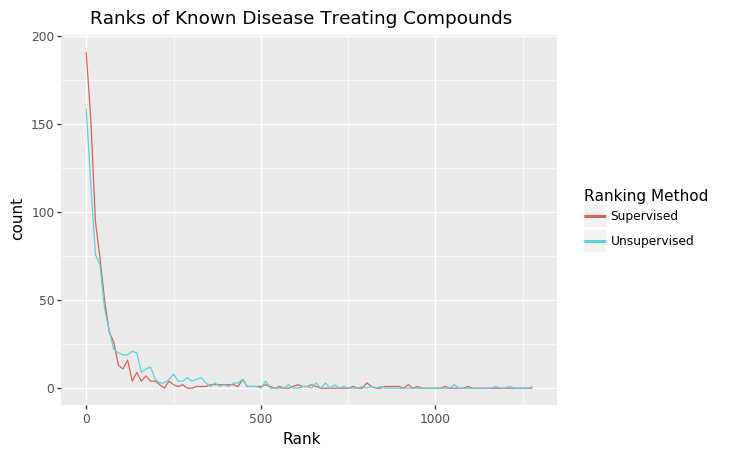

<ggplot: (8779137814897)>

In [20]:
(ggplot(melted_df, aes('Rank', color='Ranking Method')) + geom_freqpoly()
+ ggtitle('Ranks of Known Disease Treating Compounds'))

/home/benheil/miniconda3/envs/hetmech/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 98'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


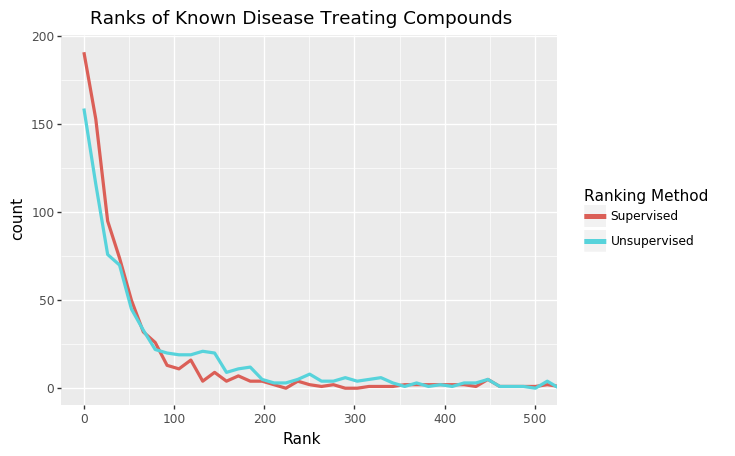

<ggplot: (-9223363257716900264)>

In [21]:
(ggplot(melted_df, aes('Rank', color='Ranking Method')) + geom_freqpoly(size=1.3)
+ coord_cartesian([0, 500]) 
+ ggtitle('Ranks of Known Disease Treating Compounds'))